In [15]:
import os
import io
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
import pdb
from PIL import Image
import torch
import torch.nn as nn
from torch.autograd import Variable
import pdb
import torch.nn.functional as F
import torchvision.utils as vutils
from torch.autograd import Variable
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt

In [2]:
output_save_path = './generated_images/'
os.makedirs(output_save_path, exist_ok=True)

In [16]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [17]:
class CustomDataset(Dataset):

    def __init__(self, datasetFile, transform=None, split=0):
        self.datasetFile = datasetFile
        self.transform = transform
        self.dataset = None
        self.dataset_keys = None
        self.split = 'train' if split == 0 else 'valid' if split == 1 else 'test'

    def __len__(self):
        f = h5py.File(self.datasetFile, 'r')
        self.dataset_keys = [str(k) for k in f[self.split].keys()]
        length = len(f[self.split])
        f.close()

        return length

    def __getitem__(self, idx):
        if self.dataset is None:
            # Open the h5py file in reading mode
            self.dataset = h5py.File(self.datasetFile, mode='r')
            
            # List of images, i.e. from <[....'image_08189_1', 'image_08189_2'...]>
            self.dataset_keys = [str(k) for k in self.dataset[self.split].keys()]
            
        # Choose an image from the list of images, i.e. from <[....'image_08189_1', 'image_08189_2'...]>
        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]
        
        # Choose the required attributes of the image from ['img', 'embeddings', 'class', 'txt']
        right_image = bytes(np.array(example['img']))
        right_embed = np.array(example['embeddings'], dtype=float)
        wrong_image = bytes(np.array(self.find_wrong_image(example['class'])))
        inter_embed = np.array(self.find_inter_embed())
        
        # Resize image to the dimensions that the Discriminator accepts
        right_image = Image.open(io.BytesIO(right_image)).resize((64, 64))
        wrong_image = Image.open(io.BytesIO(wrong_image)).resize((64, 64))
        
        # Check if the image has 3 channels, and change if not
        right_image = self.validate_image(right_image)
        wrong_image = self.validate_image(wrong_image)

        try:
            txt = np.array(example['txt']).astype(str)
        except:
            
            txt = np.array([example['txt'][()].decode('utf-8', errors='replace')])
            txt = np.char.replace(txt, '�', ' ').astype(str)
        
        # Accumulate all the above information into a dictionary to be returned
        sample = {
                'right_images': torch.FloatTensor(right_image),
                'right_embed': torch.FloatTensor(right_embed),
                'wrong_images': torch.FloatTensor(wrong_image),
                'inter_embed': torch.FloatTensor(inter_embed),
                'txt': str(txt)
                 }
        
        # Bring all the pixel values of the image in the range 0 to 1,
        # since they are all in the range 0 to 255
        sample['right_images'] = sample['right_images'].sub_(127.5).div_(127.5)
        sample['wrong_images'] =sample['wrong_images'].sub_(127.5).div_(127.5)

        return sample
    
    # Find a random wrong image
    def find_wrong_image(self, category):
        idx = np.random.randint(len(self.dataset_keys))
        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]
        _category = example['class']
        
        # Return, if the chosen wrong image is from a different category
        if _category != category:
            return example['img']
        
        # Otherwise, run the function again, until a proper wrong image is found
        return self.find_wrong_image(category)
    
    # Find a random embedding
    def find_inter_embed(self):
        idx = np.random.randint(len(self.dataset_keys))
        example_name = self.dataset_keys[idx]
        example = self.dataset[self.split][example_name]
        return example['embeddings']

    
    # Convert the images into 3 channels
    def validate_image(self, img):
        img = np.array(img, dtype=float)
        if len(img.shape) < 3:
            rgb = np.empty((64, 64, 3), dtype=np.float32)
            rgb[:, :, 0] = img
            rgb[:, :, 1] = img
            rgb[:, :, 2] = img
            img = rgb

        return img.transpose(2, 0, 1)

In [18]:
# Generator class
class Generator(nn.Module):
    def __init__(self, channels, noise_dim=100, embed_dim=1024, embed_out_dim=128):
        super(Generator, self).__init__()
        self.channels = channels
        self.noise_dim = noise_dim
        self.embed_dim = embed_dim
        self.embed_out_dim = embed_out_dim

        # Text embedding layers
        self.text_embedding = nn.Sequential(
            nn.Linear(self.embed_dim, self.embed_out_dim),
            nn.BatchNorm1d(self.embed_out_dim),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        
        self.relu = nn.ReLU(True)
         #1x1 feature maps of to feature maps of 4x4
        self.l1 = nn.ConvTranspose2d(self.noise_dim + self.embed_out_dim, 512, 4, stride = 1, padding = 0, bias = False)
        self.bn1 = nn.BatchNorm2d(512)
        #4x4 feature maps of to feature maps of 8x8
        self.l2 = nn.ConvTranspose2d(512, 256, 4, stride = 2, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(256)
        #8x8 feature maps of to feature maps of 16x16
        self.l3 = nn.ConvTranspose2d(256, 128, 4, stride = 2, padding = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(128)
        #128 feature maps of 16x16 to 64 feature maps of 32x32
        self.l4 = nn.ConvTranspose2d(128, 64, 4, stride = 2, padding = 1, bias = False)
        self.bn4 = nn.BatchNorm2d(64)
        #32x32 feature maps of to 3(number of channels (r, g, b)) feature maps of 64x64
        self.l5 = nn.ConvTranspose2d(64, self.channels, 4, stride = 2, padding = 1, bias = False)
        self.out = nn.Tanh()

    def forward(self, noise, text):
         # Convert embedding of 1024 size to embedding of 128 size
        text = self.text_embedding(text)
        # Reshape to match the generator input size
        text = text.view(text.shape[0], text.shape[1], 1, 1)
          # Concatenate text embedding with noise
        x = torch.cat([text, noise], 1)
        x = self.l1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.l2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.l3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.l4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.l5(x)
        x = self.out(x)
        return x


# The Embedding model
class Embedding(nn.Module):
    def __init__(self, size_in, size_out):
        super(Embedding, self).__init__()
        self.text_embedding = nn.Sequential(
            nn.Linear(size_in, size_out),
            nn.BatchNorm1d(size_out),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x, text):
        embed_out = self.text_embedding(text)
        #4x4x1x1 --> 1x1x4x4 Resize to match the discriminator input size
        embed_out_resize = embed_out.repeat(4, 4, 1, 1).permute(2, 3, 0, 1)
        # Concatenate text embedding with the input feature map
        out = torch.cat([x, embed_out_resize], 1)
        return out


# The Discriminator model
class Discriminator(nn.Module):
    def __init__(self, channels, embed_dim=1024, embed_out_dim=128):
        super(Discriminator, self).__init__()
        self.channels = channels
        self.embed_dim = embed_dim
        self.embed_out_dim = embed_out_dim

        # Discriminator architecture
        
        self.lrelu = nn.LeakyReLU(0.2, inplace = True)
        # 3 feature maps of 64x64(original image) to 64 feature maps of 32x32
        self.l1 = nn.Conv2d(self.channels, 64, 4, stride = 2, padding = 1)
        # 64 feature maps of 32x32 to 128 feature maps of 16x16
        self.l2 = nn.Conv2d(64, 128, 4, stride = 2, padding = 1)
        self.bn2 = nn.BatchNorm2d(128)
        # 128 feature maps of 16x16 to 256 feature maps of 8x8
        self.l3 = nn.Conv2d(128, 256, 4, stride = 2, padding = 1)
        self.bn3 = nn.BatchNorm2d(256)
        # 256 feature maps of 8x8 to 512 feature maps of 4x4
        self.l4 = nn.Conv2d(256, 512, 4, stride = 2, padding = 1)
        self.bn4 = nn.BatchNorm2d(512)
        # 512 feature maps of 4x4 to 1 feature map of 1x1 and
        #sigmoid function to convert the output to any value between 0 and 1 (probability)
        self.outl1 = nn.Conv2d(512 + self.embed_out_dim, 1, 4, stride = 1, padding = 0)
        self.sig = nn.Sigmoid()
        
        # Embedding layer
        self.text_embedding = Embedding(self.embed_dim, self.embed_out_dim)
        # 512 feature maps of 4x4 to 1 feature map of 1x1 and
        #sigmoid function to convert the output to any value between 0 and 1 (probability)
        self.output = nn.Sequential(
            nn.Conv2d(512 + self.embed_out_dim, 1, 4, 1, 0, bias=False), nn.Sigmoid()
        )
        

    def forward(self, x, text):
        
        x = self.l1(x)
        x = self.lrelu(x)
        x = self.l2(x)
        x = self.bn2(x)
        x = self.lrelu(x)
        x = self.l3(x)
        x = self.bn3(x)
        x = self.lrelu(x)
        x = self.l4(x)
        x = self.bn4(x)
        x = self.lrelu(x)
        # Extract features from the input using the discriminator
         # Convert 1024 text embedding to 128 and concat it with the 4x4 feature maps
        y = self.text_embedding(x, text)
        # Find the probability of the image being real or fake
        y = self.outl1(y)
        y = self.sig(y)
         # Return single-dimensional probability and the extracted features
        return y.squeeze(), x

In [19]:
# device = xm.xla_device()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using Device", device)

Using Device cuda


In [20]:
# Initialize a few hyperparameters
noise_dim = 100
embed_dim = 1024
embed_out_dim = 128
batch_size = 256
real = 1.
fake = 0.
learning_rate = 0.001
l1_c = 50
l2_c = 100
epochs = 100
log_interval = 18

In [21]:
# Pass dataset through the custom dataset formatter
train_dataset = CustomDataset('/kaggle/input/flowershd5dataset/data/flowers/flowers.hdf5',split=0) # split { 0: train, 1: validation, 2: test }
# Pass the formatted dataset through the custom dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True,num_workers=4)
print("No of batches: ",len(train_loader))

No of batches:  115


In [22]:
# Initialize loss functions
loss_fn = nn.BCELoss()
l2_loss = nn.MSELoss()
l1_loss = nn.L1Loss()

In [23]:
# Initialize lists to record losses of Generator and Discriminator
D_losses = []
G_losses = []

In [24]:
# Create a Generator object and initialize weights
generator = Generator(channels=3, embed_dim=embed_dim, noise_dim=noise_dim, embed_out_dim=embed_out_dim).to(device)
generator.apply(weights_init)

Generator(
  (text_embedding): Sequential(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (relu): ReLU(inplace=True)
  (l1): ConvTranspose2d(228, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [25]:
# Create a Discriminator object and initialize weights
discriminator = Discriminator(channels=3, embed_dim=embed_dim, embed_out_dim=embed_out_dim).to(device)
discriminator.apply(weights_init)

Discriminator(
  (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
  (l1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (l2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (outl1): Conv2d(640, 1, kernel_size=(4, 4), stride=(1, 1))
  (sig): Sigmoid()
  (text_embedding): Embedding(
    (text_embedding): Sequential(
      (0): Linear(in_features=1024, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
   

In [26]:
# Initialize optimizers for Generators and Discriminators
optim_G = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
optim_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

In [27]:
for epoch in range(epochs):
    
    batch_time = time.time()
    
    # Iterating over each batch
    for batch_idx,batch in enumerate(train_loader):
        
        # Reading the data into variables and moving them to device
        images = batch['right_images'].to(device)
        wrong_images = batch['wrong_images'].to(device)
        embeddings = batch['right_embed'].to(device)
        batch_size = images.size(0)#(256, 3, 64, 64)
        
        # TRAINING THE DISCRIMINATOR
        
        # Clear gradients for the discriminator
        optim_D.zero_grad()
        
        # Random noise to pass into Generator
        noise = torch.randn(batch_size, noise_dim, 1, 1, device=device)#(256, 100, 1, 1)
        
        # Generate fake images by passing the noise and embeddings through Generator
        fake_imgs = generator(noise, embeddings)
        
        # Forward pass real batch and calculate loss
        real_out, real_feat = discriminator(images, embeddings)
        d_loss_real = loss_fn(real_out, torch.full_like(real_out, real, device=device))
        
        # Forward pass wrong and calculate loss
        wrong_out, wrong_feat = discriminator(wrong_images, embeddings)
        d_loss_wrong = loss_fn(wrong_out, torch.full_like(wrong_out, fake, device=device))
        
        # Forward pass fake batch and calculate loss
        fake_out, fake_feat = discriminator(fake_imgs.detach(), embeddings)
        d_loss_fake = loss_fn(fake_out, torch.full_like(fake_out, fake, device=device))
        
        # Add all the above losses to find the final loss for the Discriminator
        d_loss = d_loss_real + d_loss_wrong + d_loss_fake
        
        # Backpropagate
        d_loss.backward()
        
        # Update Discriminator
        optim_D.step()
        
        # TRAINING THE GENERATOR
        
        # Clear gradients for the generator
        optim_G.zero_grad()
        
        # Generate random noise to pass through the generator
        noise = torch.randn(batch_size, noise_dim, 1, 1, device=device)
        
        # Generate fake images using the Generator
        fake_imgs = generator(noise, embeddings)
        
        # Pass it through the Discriminator, and check for output
        out_fake, feat_fake = discriminator(fake_imgs, embeddings)
        
        # Get discriminator output for the real images
        out_real, feat_real = discriminator(images, embeddings)
        
        # Calculate losses
        g_bce = loss_fn(out_fake, torch.full_like(out_fake, real, device=device))
        g_l1 = l1_c * l1_loss(fake_imgs, images)
        g_l2 = l2_c * l2_loss(torch.mean(feat_fake, 0), torch.mean(feat_real, 0).detach())
        
        # Compute total generator loss     
        g_loss = g_bce + g_l1 + g_l2
        
        # Backpropagate the gradients
        g_loss.backward()
        
        # Update the generator
        optim_G.step()
        
        # adding loss to the list
        D_losses.append(d_loss.item())
        G_losses.append(g_loss.item())
        
        # progress based on log_interval
        if (batch_idx+1) % log_interval == 0 and batch_idx > 0:
            print('Epoch {} [{}/{}] loss_D: {:.4f} loss_G: {:.4f} time: {:.2f}'.format(
                          epoch+1, batch_idx+1, len(train_loader),
                          d_loss.mean().item(),
                          g_loss.mean().item(),
                          time.time() - batch_time))
        

        if batch_idx == len(train_loader)-1 and ((epoch+1)%10==0 or epoch==0):
            viz_sample = torch.cat((images[:32], fake_imgs[:32]), 0)
            vutils.save_image(viz_sample,
            os.path.join(output_save_path, 'output_epoch_{}.png'.format(epoch+1)),
                              nrow=8,normalize=True)

Epoch 1 [18/115] loss_D: 4.4748 loss_G: 29.6106 time: 34.16
Epoch 1 [36/115] loss_D: 1.5365 loss_G: 23.3695 time: 54.89
Epoch 1 [54/115] loss_D: 1.7526 loss_G: 22.5023 time: 77.65
Epoch 1 [72/115] loss_D: 2.1926 loss_G: 24.5161 time: 96.90
Epoch 1 [90/115] loss_D: 1.9617 loss_G: 22.8528 time: 119.58
Epoch 1 [108/115] loss_D: 2.4177 loss_G: 24.1390 time: 138.51
Epoch 2 [18/115] loss_D: 1.6814 loss_G: 23.2283 time: 23.50
Epoch 2 [36/115] loss_D: 1.7384 loss_G: 22.7992 time: 42.65
Epoch 2 [54/115] loss_D: 1.9152 loss_G: 23.1914 time: 65.03
Epoch 2 [72/115] loss_D: 1.7884 loss_G: 23.3910 time: 83.56
Epoch 2 [90/115] loss_D: 1.5815 loss_G: 23.2724 time: 105.75
Epoch 2 [108/115] loss_D: 1.6625 loss_G: 24.5748 time: 124.74
Epoch 3 [18/115] loss_D: 1.6278 loss_G: 23.3503 time: 23.39
Epoch 3 [36/115] loss_D: 1.5702 loss_G: 23.1392 time: 42.56
Epoch 3 [54/115] loss_D: 1.8682 loss_G: 24.0619 time: 64.85
Epoch 3 [72/115] loss_D: 1.6674 loss_G: 23.2192 time: 83.54
Epoch 3 [90/115] loss_D: 1.6910 lo

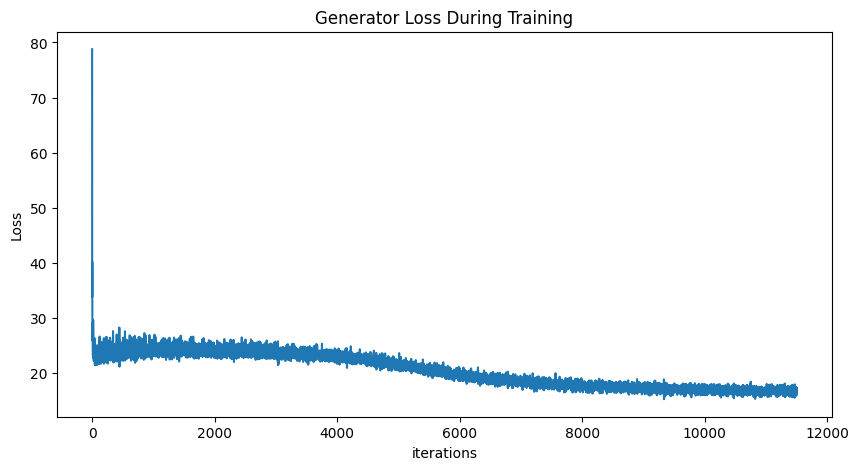

<Figure size 640x480 with 0 Axes>

In [28]:
# print(G_losses)

plt.figure(figsize=(10,5))
plt.title("Generator Loss During Training")
plt.plot(G_losses)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.show()
plt.savefig(os.path.join('./generated_images/' , 'GLoss2.png'))

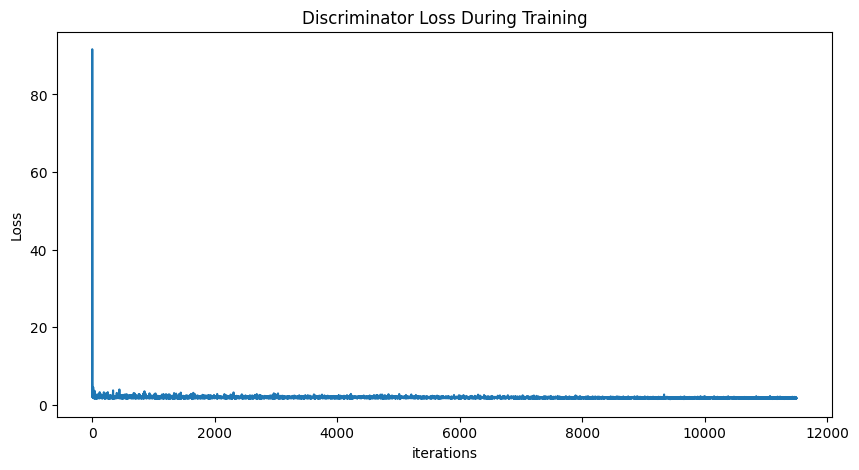

<Figure size 640x480 with 0 Axes>

In [29]:
# print(D_losses)

plt.figure(figsize=(10,5))
plt.title("Discriminator Loss During Training")
plt.plot(D_losses)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.show()

plt.savefig(os.path.join(output_save_path, 'DLoss2.png'))

In [32]:
batch_size = 10
# Pass dataset through the custom dataset formatter
test_dataset = CustomDataset('/kaggle/input/flowershd5dataset/data/flowers/flowers.hdf5',split=2) # split { 0: train, 1: validation, 2: test }
# Pass the formatted dataset through the custom dataloader
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True,num_workers=4)
print("No of batches: ",len(test_loader))

No of batches:  578


Batch 1/578
------------------------------------------------------------------------------------------


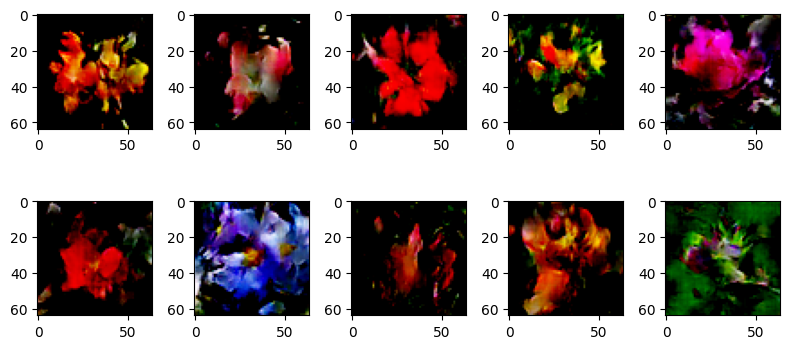

Batch 2/578
------------------------------------------------------------------------------------------


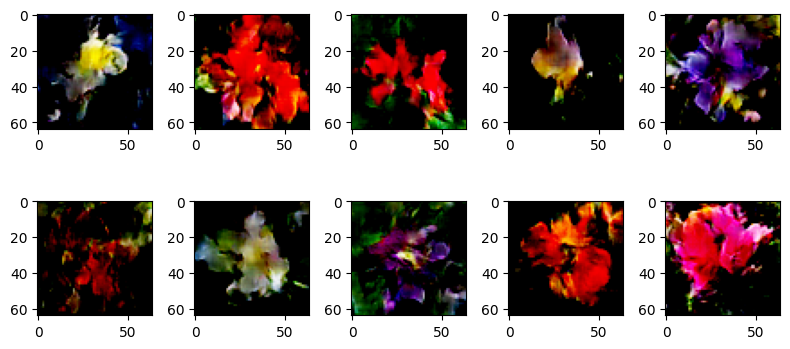

Batch 3/578
------------------------------------------------------------------------------------------


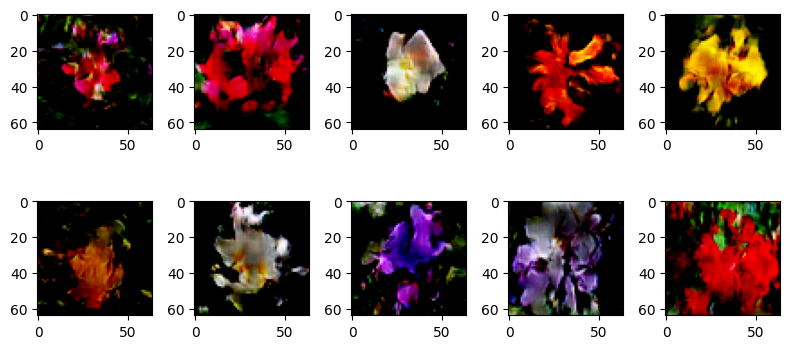

Batch 4/578
------------------------------------------------------------------------------------------


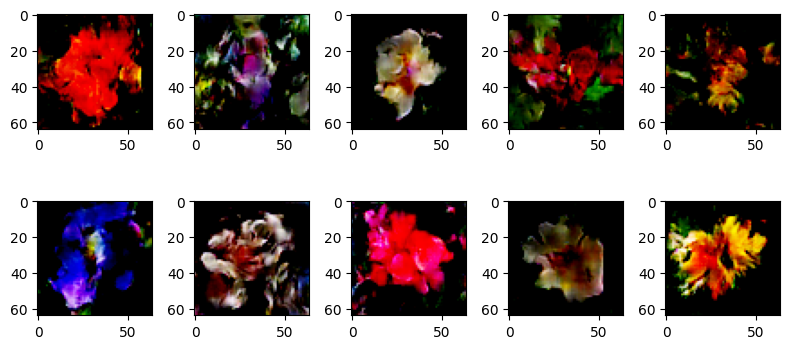

Batch 5/578
------------------------------------------------------------------------------------------


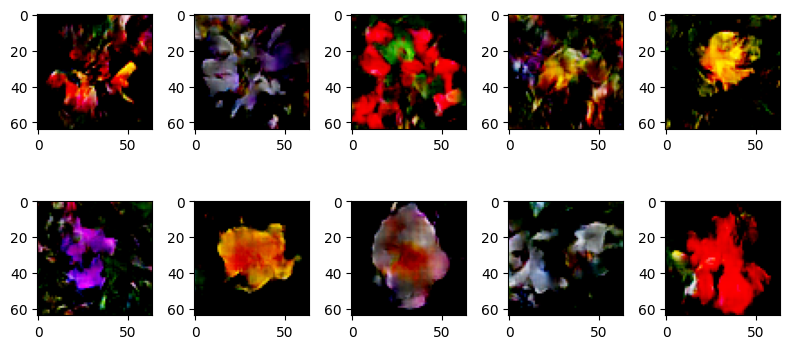

Batch 6/578
------------------------------------------------------------------------------------------


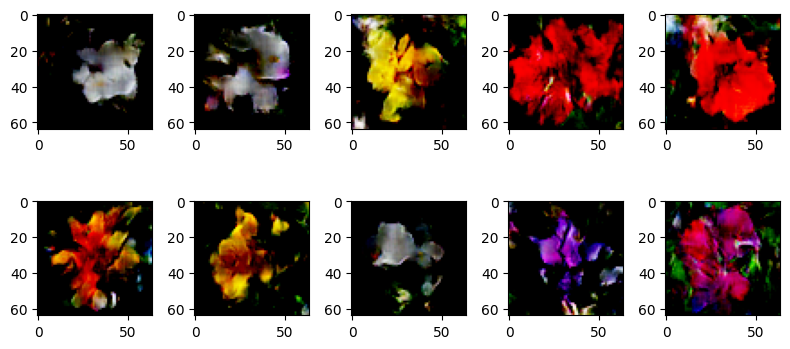

Batch 7/578
------------------------------------------------------------------------------------------


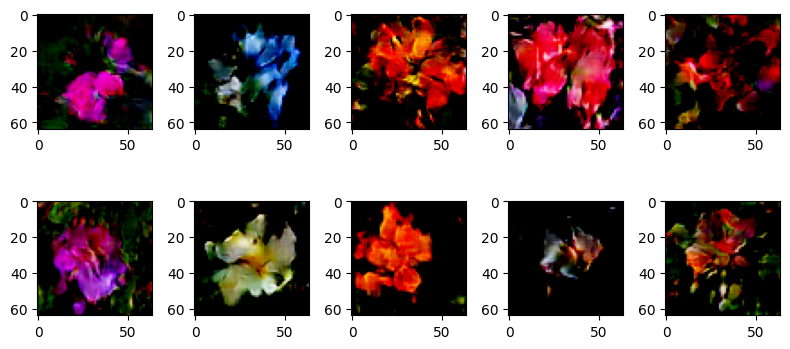

Batch 8/578
------------------------------------------------------------------------------------------


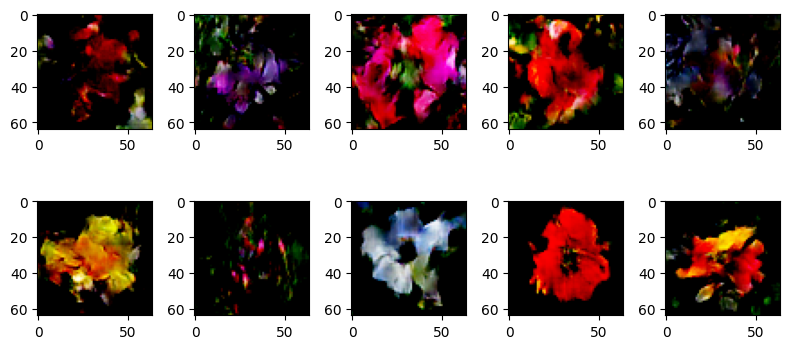

Batch 9/578
------------------------------------------------------------------------------------------


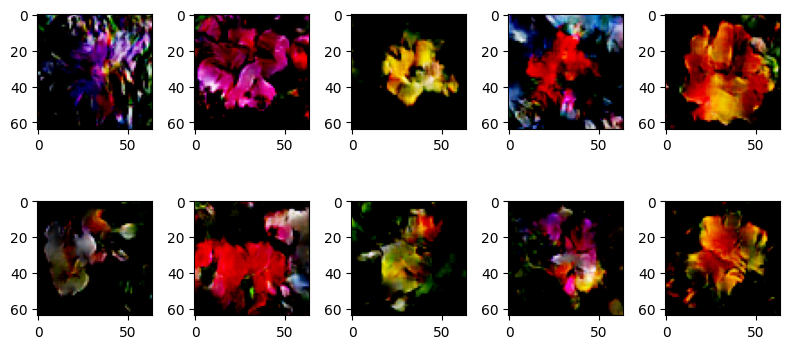

Batch 10/578
------------------------------------------------------------------------------------------


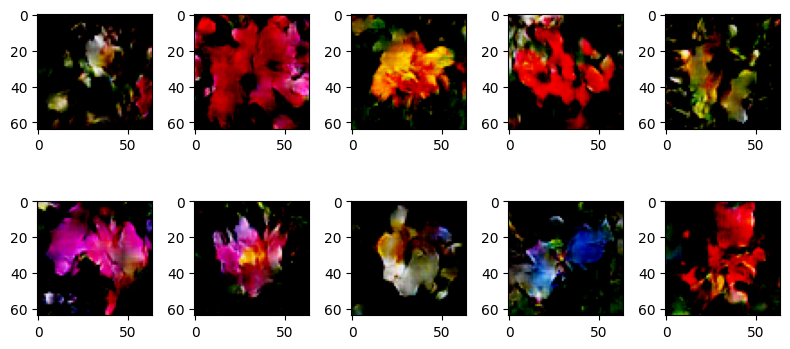

Batch 11/578
------------------------------------------------------------------------------------------


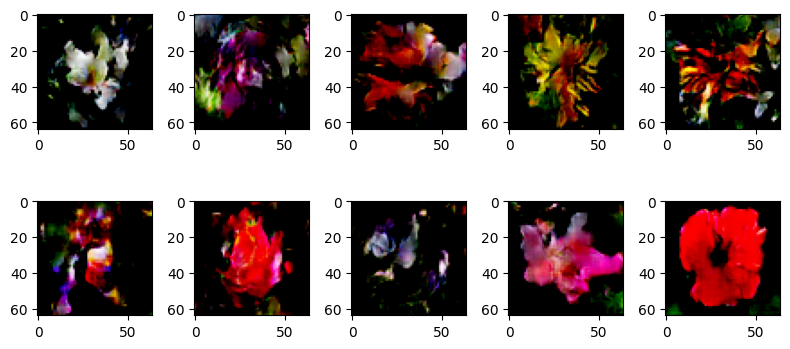

Batch 12/578
------------------------------------------------------------------------------------------


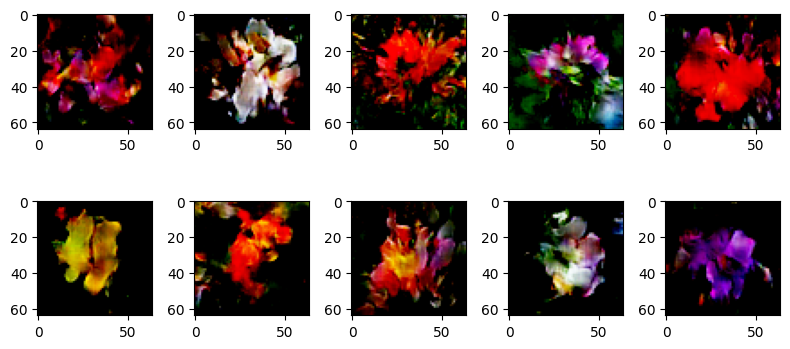

Batch 13/578
------------------------------------------------------------------------------------------


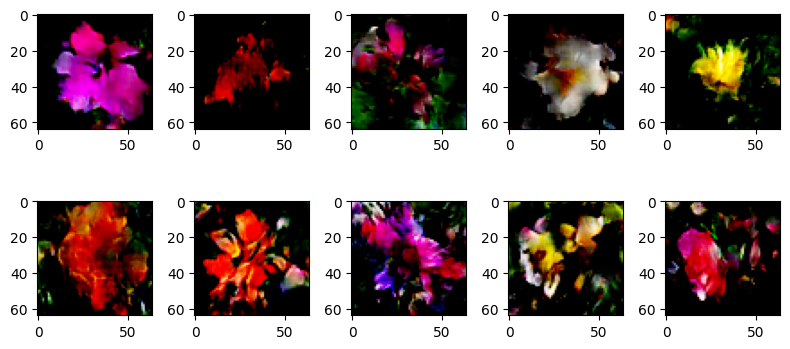

Batch 14/578
------------------------------------------------------------------------------------------


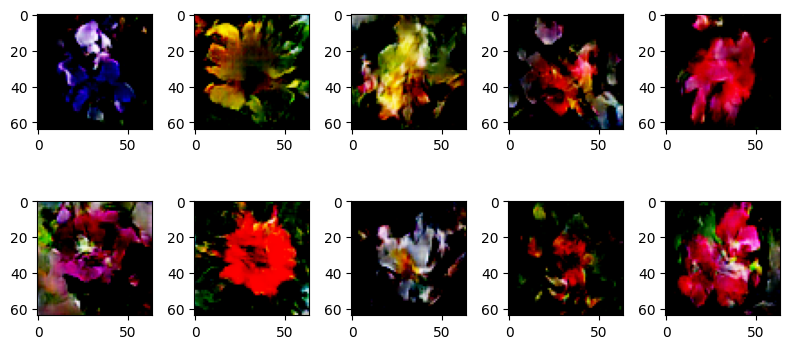

Batch 15/578
------------------------------------------------------------------------------------------


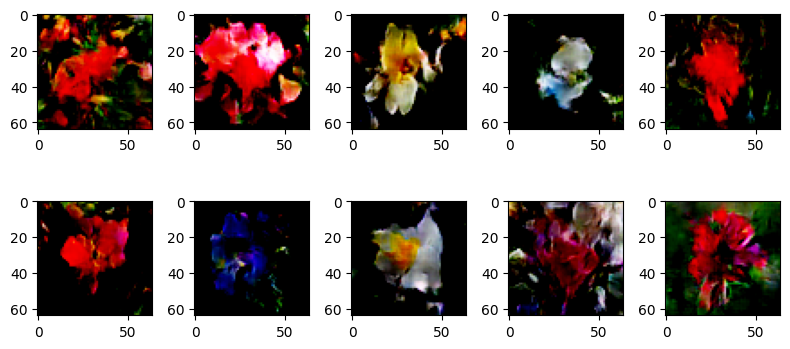

Batch 16/578
------------------------------------------------------------------------------------------


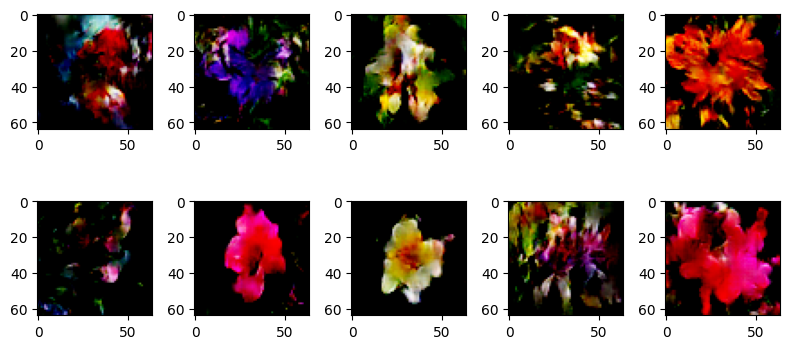

Batch 17/578
------------------------------------------------------------------------------------------


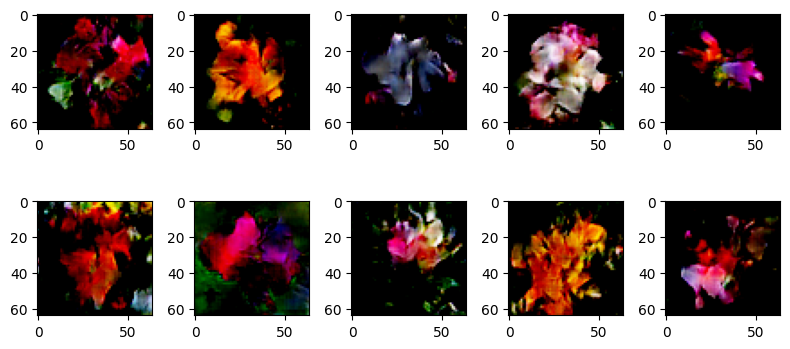

Batch 18/578
------------------------------------------------------------------------------------------


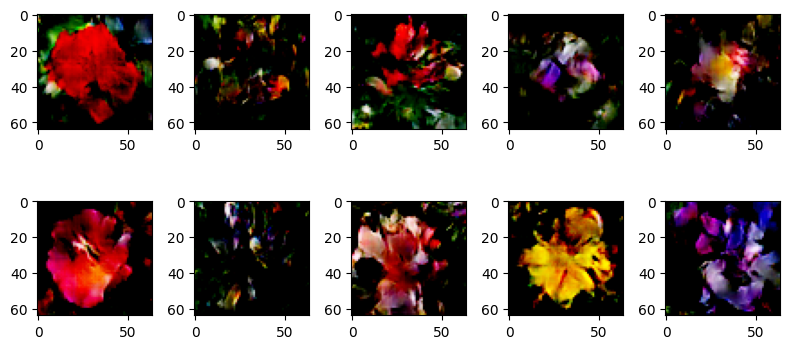

Batch 19/578
------------------------------------------------------------------------------------------


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

with torch.no_grad():
    for i, batch in enumerate(test_loader):
        embeddings = batch['right_embed'].to(device)
        noise = torch.randn(batch_size, noise_dim, 1, 1, device=device)
        fake_images = generator(noise, embeddings)
        fig, axes = plt.subplots(2, 5, figsize=(8, 4))
        for j, tensor_image in enumerate(fake_images):
            # Convert tensor to numpy array
            numpy_image = tensor_image.cpu().numpy()

            # Normalize the image data
            if numpy_image.dtype == np.uint8:
                numpy_image = numpy_image.astype(np.float32) / 255.0  # Normalize to [0, 1] range
            else:
                numpy_image = numpy_image.clip(0, 1)  # Clip values to [0, 1] range

            # Bring number of channels to the last dimension
            if numpy_image.shape[0] == 3:
                numpy_image = np.transpose(numpy_image, (1, 2, 0))

            # Plot the image on the corresponding axis
            row = j // 5
            col = j % 5
            axes[row, col].imshow(numpy_image)

        # Adjust layout
        plt.tight_layout()

        # Show the plot
        print('Batch {}/{}'.format(i+1, 578))
        print('-'*90)
        plt.show()


In [ ]:
# print(D_losses)
import matplotlib.pyplot as plt

def generate_ROC_curve(generator_losses, discriminator_losses):
    # Convert percentage losses to decimals
    generator_losses = [loss / 100.0 for loss in generator_losses]
    discriminator_losses = [loss / 100.0 for loss in discriminator_losses]

    # Create a dataset with generator and discriminator losses
    dataset = [(generator_loss, discriminator_loss) for generator_loss, discriminator_loss in zip(generator_losses, discriminator_losses)]

    # Sort the dataset by discriminator loss
    sorted_dataset = sorted(dataset, key=lambda x: x[1])

    # Initialize lists to store FPR and TPR
    FPRs = []
    TPRs = []

    # Calculate total number of real and fake samples
    total_real_samples = sum(1 for _, d_loss in dataset)
    total_fake_samples = total_real_samples

    # Iterate through sorted dataset to calculate FPR and TPR
    for generator_loss, discriminator_loss in sorted_dataset:
        # Calculate number of fake samples with discriminator loss greater than current sample
        false_positive = sum(1 for _, d_loss in sorted_dataset if d_loss > discriminator_loss)
        # Calculate number of real samples with discriminator loss greater than current sample
        true_positive = sum(1 for _, d_loss in sorted_dataset if d_loss <= discriminator_loss)

        # Calculate FPR and TPR
        FPR = false_positive / total_fake_samples
        TPR = true_positive / total_real_samples

        # Append FPR and TPR to lists
        FPRs.append(FPR)
        TPRs.append(TPR)

    # Plot ROC curve
    plt.plot(FPRs, TPRs)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for GAN')
    plt.show()

# Example usage:
# generator_losses = [10, 20, 30, 40, 50]  # percentages
# discriminator_losses = [30, 40, 20, 60, 10]  # percentages

generate_ROC_curve(G_losses, D_losses)
